In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('linear_regression_adv').getOrCreate()

# If you're getting an error with numpy, please type 'sudo pip install numpy --user' into the EC2 console.
from pyspark.ml.regression import LinearRegression

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/09 14:30:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# data processing from section 03
from pyspark.sql.types import (StructField,StringType,IntegerType,FloatType,StructType)
data_schema = [StructField('Entity',StringType(),True),
              StructField('Code',StringType(),True),
              StructField('Year',IntegerType(),True),
              StructField('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized',FloatType(),True)]
final_struct = StructType(fields=data_schema)
death_df = spark.read.csv("unsafewaterdeathrate.csv",schema=final_struct,header=True)

data_schema = [StructField('Entity',StringType(),True),
              StructField('Code',StringType(),True),
              StructField('Year',IntegerType(),True),
              StructField('GDP per capita, PPP (constant 2017 international $)',FloatType(),True)]
final_struct = StructType(fields=data_schema)
gdp_df = spark.read.csv("gdp-per-capita-worldbank.csv",schema=final_struct,header=True)

data_schema = [StructField('Type',StringType(),True),
              StructField('Region',StringType(),True),
              StructField("Residence Type",StringType(),True),
              StructField("Service Type",StringType(),True),
              StructField('Year',IntegerType(),True),
              StructField('Coverage',FloatType(),True),
              StructField('Population',FloatType(),True),
              StructField('Facility type',StringType(),True)]
final_struct = StructType(fields=data_schema)
wash_df = spark.read.csv("WASH.csv",schema=final_struct,header=True)

wash_df = wash_df.drop('Type')
death_df = death_df.drop('Code')

from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType, FloatType, DoubleType

numeric_cols = [f.name for f in wash_df.schema.fields if isinstance(f.dataType, (DoubleType, IntegerType, FloatType))]

# Identify numeric columns
numeric_cols = [f.name for f in wash_df.schema.fields if isinstance(f.dataType, (DoubleType, IntegerType, FloatType))]

for column in numeric_cols:
    Q1, Q3 = wash_df.approxQuantile(column, [0.25, 0.75], 0.05)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Coerce outliers using withColumn and when
    wash_df = wash_df.withColumn(column, 
                                 when(col(column) > upper_bound, upper_bound)
                                 .when(col(column) < lower_bound, lower_bound)
                                 .otherwise(col(column)))
    
Q1, Q3 = death_df.approxQuantile('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized', [0.25, 0.75], 0.05)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with closest point
death_df = death_df.withColumn ('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized', 
                               when(col('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized') < lower_bound, lower_bound)
                               .when(col('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized') > upper_bound, upper_bound)
                               .otherwise(col('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized')))

# filter irrelevant years
wash_df = wash_df.filter((col('Year') >= 2012) & (col('Year') <= 2019))
death_df = death_df.filter((col('Year') >= 2012) & (col('Year') <= 2019))
death_df = death_df.withColumnRenamed('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized', 'MortalityRate')
gdp_df = gdp_df.filter((col('Year') >= 2012) & (col('Year') <= 2019))

# compute the mean gdp by country
from pyspark.sql.functions import avg
mean_gdp_by_country = gdp_df.groupBy('Entity').agg(avg('GDP per capita, PPP (constant 2017 international $)')\
                                                   .alias('Mean GDP'))
# convert into incomelevels
income_category = mean_gdp_by_country.withColumn("IncomeLevel",
    when(col("`Mean GDP`") <= 1897.289, "Low income")
    .when((col("`Mean GDP`") > 1897.289) & (col("`Mean GDP`") <= 6464.184), "Lower middle income")
    .when((col("`Mean GDP`") > 6464.184) & (col("`Mean GDP`") <= 15324.779), "Upper middle income")
    .otherwise("High income")
)

death_gdp_df = death_df.join(income_category, death_df["Entity"] \
                             == income_category["Entity"], how='inner').drop(income_category["Entity"])

wash_df = wash_df.withColumnRenamed("Region", "IncomeLevel")

final_df = wash_df.join(death_gdp_df, on=['Year', 'IncomeLevel'], how='inner')

from pyspark.sql.types import IntegerType, DoubleType

final_df = (final_df.withColumn("Year", final_df["Year"].cast(IntegerType()))
                   .withColumn("Coverage", final_df["Coverage"].cast(DoubleType()))
                   .withColumn("MortalityRate", final_df["MortalityRate"].cast(DoubleType()))
                   .withColumn("Population", final_df["Population"].cast(DoubleType()))
                   .withColumn("Mean GDP", final_df["Mean GDP"].cast(DoubleType())))

from pyspark.sql.functions import col, when

final_df = final_df.withColumn("IncomeLevel", 
                               when(col("IncomeLevel") == "Lower middle income", 1)
                               .when(col("IncomeLevel") == "Upper middle income", 2)
                               .when(col("IncomeLevel") == "High income", 3)
                               .when(col("IncomeLevel") == "Low income", 0)
                               .otherwise(col("IncomeLevel")))

final_df = final_df.withColumn("Service Type", 
                               when(col("Service Type") == "Sanitation", 1)
                               .when(col("Service Type") == "Drinking water", 2)
                               .otherwise(col("Service Type")))

final_df = final_df.withColumn("Residence Type", 
                               when(col("Residence Type") == "total", 1)
                               .when(col("Residence Type") == "rural", 2)
                               .when(col("Residence Type") == "urban", 3)
                               .otherwise(col("Residence Type")))

final_df = final_df.withColumn("Facility type", 
                               when(col("Facility type") == "Improved latrine and other", 1)
                               .when(col("Facility type") == "Septic tank", 2)
                               .when(col("Facility type") == "Sewer", 3)
                               .when(col("Facility type") == "Non-piped improved", 4)
                               .when(col("Facility type") == "Piped improved", 5)
                               .otherwise(col("Facility type")))

final_df = (final_df.withColumn("IncomeLevel", final_df["IncomeLevel"].cast(IntegerType()))
                   .withColumn("Residence Type", final_df["Residence Type"].cast(IntegerType()))
                   .withColumn("Service Type", final_df["Service Type"].cast(IntegerType()))
                   .withColumn("Facility type", final_df["Facility type"].cast(IntegerType()))
           )

In [3]:
final_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- IncomeLevel: integer (nullable = true)
 |-- Residence Type: integer (nullable = true)
 |-- Service Type: integer (nullable = true)
 |-- Coverage: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Facility type: integer (nullable = true)
 |-- Entity: string (nullable = true)
 |-- MortalityRate: double (nullable = true)
 |-- Mean GDP: double (nullable = true)



## Spark Formatting Data

In [4]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
feature_cols = ['Coverage','IncomeLevel','MortalityRate','Residence Type','Facility type']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
final_spk = assembler.transform(final_df)
final_spk.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- IncomeLevel: integer (nullable = true)
 |-- Residence Type: integer (nullable = true)
 |-- Service Type: integer (nullable = true)
 |-- Coverage: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Facility type: integer (nullable = true)
 |-- Entity: string (nullable = true)
 |-- MortalityRate: double (nullable = true)
 |-- Mean GDP: double (nullable = true)
 |-- features: vector (nullable = true)



In [5]:
final_data = final_spk.select("features",'MortalityRate')
final_data.show()

+--------------------+-----------------+
|            features|    MortalityRate|
+--------------------+-----------------+
|[69.4499435424804...|7.417001601308584|
|[22.6206798553466...|7.417001601308584|
|[38.1135101318359...|7.417001601308584|
|[24.0316905975341...|7.417001601308584|
|[43.2337989807128...|7.417001601308584|
|[36.8950500488281...|7.417001601308584|
|[16.1666393280029...|7.417001601308584|
|[2.22553992271423...|7.417001601308584|
|[6.84026002883911...|7.417001601308584|
|[14.1804399490356...|7.417001601308584|
|[2.72841000556945...|7.417001601308584|
|[6.51758003234863...|7.417001601308584|
|[39.3636093139648...|7.417001601308584|
|[24.8787498474121...|7.417001601308584|
|[29.6881599426269...|7.417001601308584|
|[69.1036834716796...|7.417001601308584|
|[21.9623699188232...|7.417001601308584|
|[37.3481788635253...|7.417001601308584|
|[23.8663291931152...|7.417001601308584|
|[42.3547210693359...|7.417001601308584|
+--------------------+-----------------+
only showing top

In [6]:
train_data,test_data = final_data.randomSplit([0.8,0.2])

In [7]:
# Let's see our training data.
train_data.describe().show()

# And our testing data.
test_data.describe().show()

+-------+-------------------+
|summary|      MortalityRate|
+-------+-------------------+
|  count|              18291|
|   mean| 1.6314203507208174|
| stddev|   2.25300450811116|
|    min|6.19291327893734E-4|
|    max|  7.417001601308584|
+-------+-------------------+

+-------+-------------------+
|summary|      MortalityRate|
+-------+-------------------+
|  count|               4389|
|   mean| 1.6296696137060207|
| stddev| 2.2291505491993147|
|    min|6.19291327893734E-4|
|    max|  7.417001601308584|
+-------+-------------------+



In [8]:
lr = LinearRegression(labelCol='MortalityRate',regParam=0.01)
lrModel = lr.fit(train_data)
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

23/10/09 14:31:32 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/09 14:31:32 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/10/09 14:31:33 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Coefficients: [-1.4450546766994433e-05,-0.019868455261159223,0.9887716063623679,6.503053437211121e-06,0.00013537631816660302] Intercept: 0.058310707740846464


In [9]:
test_results = lrModel.evaluate(test_data)

In [10]:
test_results.residuals.show()

# Let's get some evaluation metrics (as discussed in the previous linear regression notebook).
print("RSME: {}".format(test_results.rootMeanSquaredError))

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+
|           residuals|
+--------------------+
|7.897067216802167E-4|
|8.004807127642496E-4|
|8.546901787016281E-4|
|  8.6409685735888E-4|
|9.385373708705874E-4|
|9.523609436872041E-4|
|0.001022223824550...|
|0.001134545550941...|
|0.002019557848104092|
|0.002223112360906...|
|0.016813714398783874|
|8.104360024384985E-4|
|8.202197227064612E-4|
|8.919287955992117E-4|
|9.311246947625515E-4|
|9.684609904648395E-4|
|9.877825495293452E-4|
|0.001026305200063804|
|0.001032035421063407|
|0.001303327377350...|
+--------------------+
only showing top 20 rows

RSME: 0.015571922178768976


In [11]:
# We can also get the R2 value. 
print("R2: {}".format(test_results.r2))

R2: 0.9999511904716819


In [12]:
print("P-values for each coefficient and intercept: ", lrModel.summary.pValues)

P-values for each coefficient and intercept:  [0.002213573675013736, 0.0, 0.0, 0.963582383717914, 0.16112535036961173, 0.0]


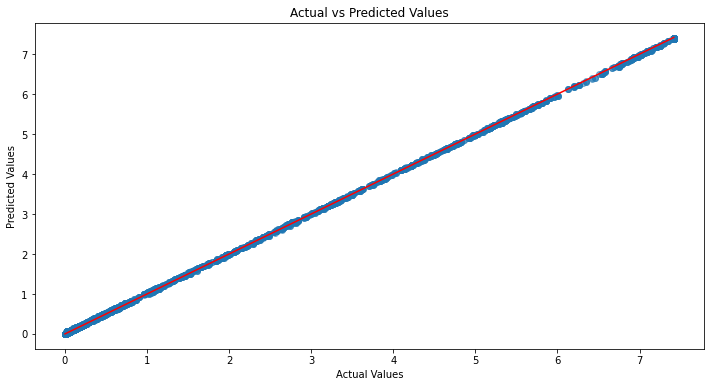

In [13]:
import matplotlib.pyplot as plt
predictions = lrModel.transform(test_data)
pdf = predictions.select("MortalityRate", "prediction").toPandas()

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(pdf["MortalityRate"], pdf["prediction"], alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot([min(pdf["MortalityRate"]), max(pdf["MortalityRate"])], [min(pdf["MortalityRate"]), max(pdf["MortalityRate"])], color='red') # y=x line
plt.show()

In [15]:
feature_cols = ['Coverage','IncomeLevel','Residence Type','Facility type']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
final_spk = assembler.transform(final_df)

In [16]:
lr2 = LinearRegression(labelCol='MortalityRate',regParam=0.01)
lrModel2 = lr2.fit(train_data)

In [20]:
test_results = lrModel2.evaluate(test_data)
print("RSME of lr2: {}".format(test_results.rootMeanSquaredError))
print("R2 of lr2: {}".format(test_results.r2))

RSME of lr2: 0.015571922178768976
R2 of lr2: 0.9999511904716819


In [21]:
feature_cols = ['Coverage','IncomeLevel','Facility type']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
final_spk = assembler.transform(final_df)

In [22]:
lr3 = LinearRegression(labelCol='MortalityRate',regParam=0.01)
lrModel3 = lr3.fit(train_data)

In [28]:
test_results = lrModel3.evaluate(test_data)
print("RSME of lr3: {}".format(test_results.rootMeanSquaredError))
print("R2 of lr3: {}".format(test_results.r2))

RSME of lr3: 0.015571922178768976
R2 of lr3: 0.9999511904716819


In [25]:
feature_cols = ['IncomeLevel','Facility type']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
final_spk = assembler.transform(final_df)

In [30]:
lr4 = LinearRegression(labelCol='MortalityRate',regParam=0.01)
lrModel4 = lr4.fit(train_data)

In [32]:
test_results = lrModel4.evaluate(test_data)
print("RSME of lr4: {}".format(test_results.rootMeanSquaredError))
print("R2 of lr4: {}".format(test_results.r2))

RSME of lr4: 0.015571922178768976
R2 of lr4: 0.9999511904716819
